In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image1 = cv2.imread('image 1.jpg')
image2 = cv2.imread('image 3.jpg')

In [3]:
image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

In [4]:
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

In [5]:
# star = cv2.xfeatures2d.StarDetector_create()
fast = cv2.FastFeatureDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

In [6]:
# keypoints1 = star.detect(image1,None)
# keypoints2 = star.detect(image2,None)

keypoints1 = fast.detect(image1,None)
keypoints2 = fast.detect(image2,None)

keypoints1, descriptors1 = brief.compute(image1, keypoints1)
keypoints2, descriptors2 = brief.compute(image2, keypoints2)


In [7]:
image1_keypoints = cv2.drawKeypoints(image1, keypoints1, None)
image2_keypoints = cv2.drawKeypoints(image2, keypoints2, None)

(-0.5, 1107.5, 1476.5, -0.5)

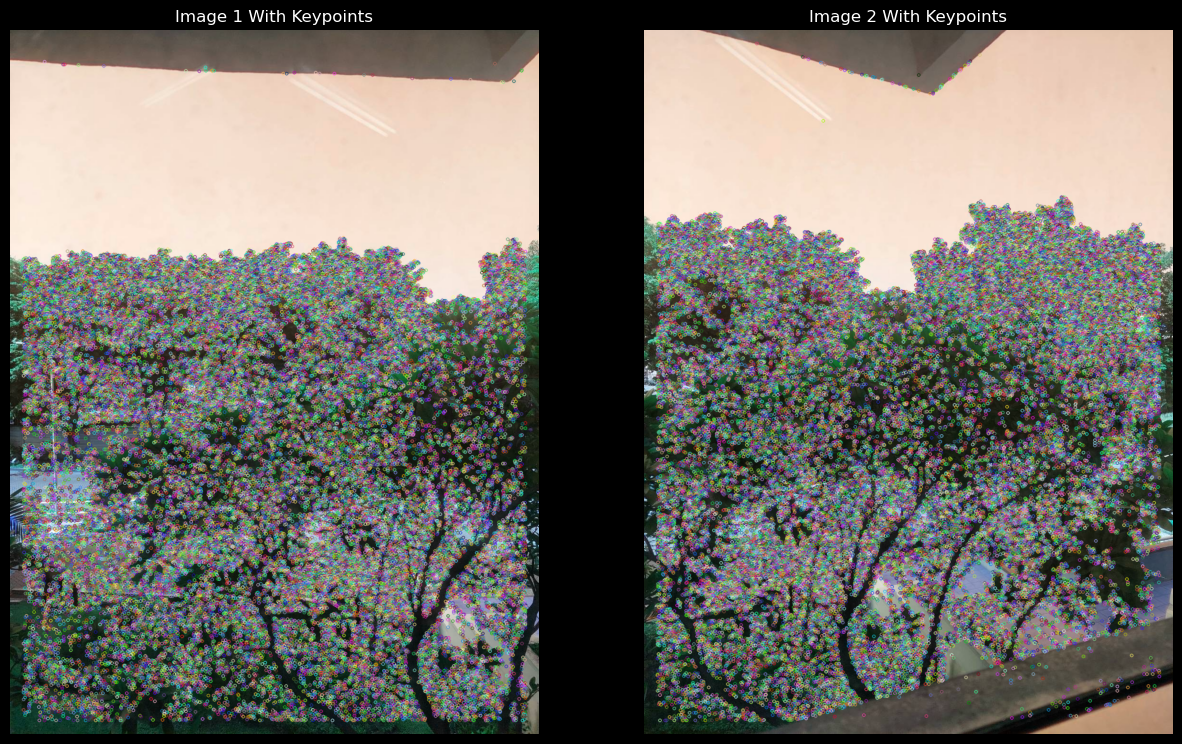

In [8]:
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(image1_keypoints, cmap='gray')
plt.title('Image 1 With Keypoints')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image2_keypoints, cmap='gray')
plt.title('Image 2 With Keypoints')
plt.axis('off')

In [9]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

In [10]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)

dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)


# Calculate Homography
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp image1 to image2
height1, width1 = gray1.shape
height2, width2 = gray2.shape
corners1 = np.array([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2).astype(np.float32)
corners2 = np.array([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2).astype(np.float32)
corners_transformed1 = cv2.perspectiveTransform(corners1, H)
corners_transformed = np.concatenate((corners2, corners_transformed1), axis=0)
[x_min, y_min] = np.int32(corners_transformed.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(corners_transformed.max(axis=0).ravel() + 0.5)
T = [-x_min, -y_min]
H_translation = np.array([[1, 0, T[0]], [0, 1, T[1]], [0, 0, 1]])
stitched_img = cv2.warpPerspective(image1, H_translation.dot(H), (x_max - x_min, y_max - y_min))
stitched_img[T[1]:height2 + T[1], T[0]:width2 + T[0]] = image2

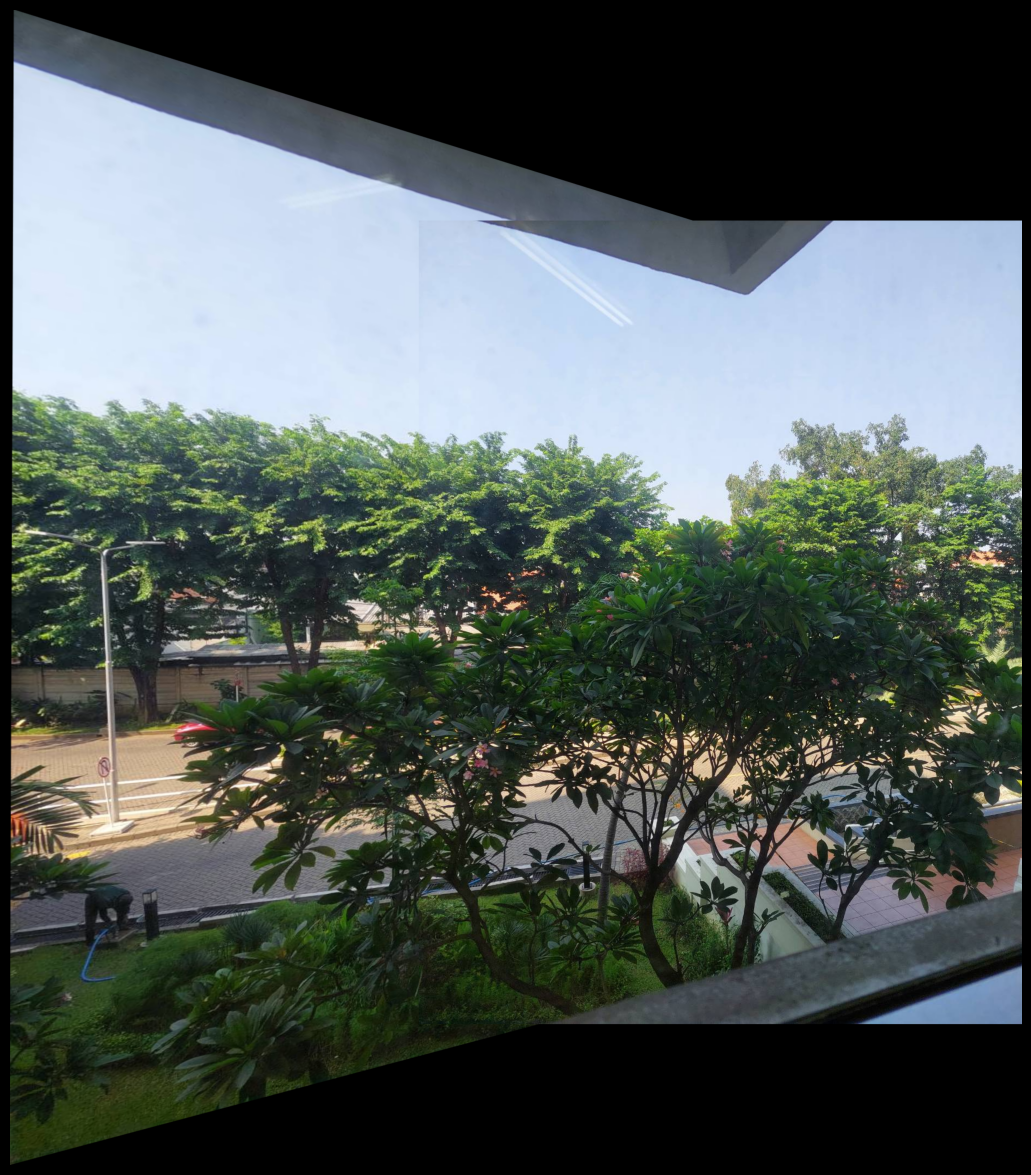

In [11]:
plt.figure(figsize=(15,15))

plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()